## Using LSTM to Predict **Apple** Stock Price - With Feature Engineering

<p> Date: 2026-11-11 &emsp;&emsp;&emsp; 
<br><br> 

**Source Data**: [New York Stock Exchange](https://www.kaggle.com/datasets/dgawlik/nyse?select=securities.csv)

**Content:** <br>
- [Background](#background)

- [Experiemnt 🧪⚗️ ](#experiment)
    
    - [Feature engineering](#2-feature-engineering): volume change, 7-day return, streak up, streak down, range ratio 

    - [Modeling](#modeling)

    - [Robustness Performance Analysis](#robustness-performance-analysis)

    - [Prediction](#Prediction)

- [Reference]() 

## Background

### 1. Stock Analysis using Recurrent Neural Networks (RNNs): LSTM = Long Short-Term Memory`;

1. Recurrent Neural Networks (RNNs) – especially LSTM/GRU
    - `LSTM = Long Short-Term Memory`; GRU = Gated Recurrent Units  
    - The classic approach: use a sequence of past price (and optionally volume/indicators) to forecast next price or return. e.g., using TensorFlow / Keras you can build a straightforward LSTM model. 
    - Example: Using x_train of shape (time_steps, features) and LSTM layers, return_sequences, etc. 
    - Also GRU variants (Gated Recurrent Units) appear in literature. 

### 2. Feature Engineering

Adding open, high, low, and volume can help, but whether it improves your model depends on multiple factors:

1. Why adding them could help
    - Open, high, low: Provide intra-day movement information. LSTM can potentially capture patterns like volatility, gaps, etc.
    - Volume: Often correlates with price momentum and can indicate strong buying/selling pressure. LSTM could learn relationships between volume spikes and price changes.

2. Why it might not help
    - **Redundancy**: Closing price is already a summary of the day. High and low may not add much signal if your prediction horizon is daily and the LSTM captures trends from closing prices.
    - **Noise**: Extra features introduce more parameters for the model to learn. If the stock’s movement is mostly trend-based and predictable from the close price alone, extra features could just add noise.
    - **Data scarcity**: For short time series (like <2000 days), adding more features increases risk of overfitting.

**Rule of thumb**: Adding more features can help but is not guaranteed. It’s better to test feature sets and validate than assume more features always improve LSTM performance.


### 2.1 Table 

| Feature Nam         | Description / How to Compute                                            | Notes / Why Useful                        |
| ------------------- | ----------------------------------------------------------------------- | ----------------------------------------- |
| Close               | Closing price of the day                                                | Baseline target for prediction            |
| Open                | Opening price                                                           | Optional: can capture gap moves           |
| High                | Daily high                                                              | Helps measure intra-day extremes          |
| Low                 | Daily low                                                               | Combined with High, gives volatility info |
| Volume              | Trading volume                                                          | Indicates buying/selling pressure         |
| **Volume_Change**       | `(Volume_t - Volume_{t-1}) / Volume_{t-1}`                              | Detects unusual volume spikes             |
| Return_1d           | `(Close_t - Close_{t-1}) / Close_{t-1}`                                 | Daily return / momentum                   |
| **Return_7d**           | `(Close_t - Close_{t-7}) / Close_{t-7}`                                 | Short-term momentum                       |
| **Streak_Up**           | Count of consecutive days `Close_t > Close_{t-1}`                       | Captures buying pressure                  |
| **Streak_Down**         | Count of consecutive days `Close_t < Close_{t-1}`                       | Captures selling pressure                 |
| ATR_7               | Average True Range over 7 days: mean of `(High - Low)` or `(max - min)` | Measures short-term volatility            |
| MA_5                | 5-day moving average of close                                           | Trend indicator                           |
| MA_10               | 10-day moving average of close                                          | Trend indicator                           |
| MA_ratio            | `MA_5 / MA_10`                                                          | Crossovers may indicate momentum shifts   |
| Price_Volume_Signal | `Return_1d * Volume_Change`                                             | Combined price + volume momentum signal   |
| True Range(TR)      | `max(High - Low, abs(High - PrevClose), abs(Low - PrevClose))           | Captures true daily volatility including overnight gaps |
|**Range Ratio**      | `(High - Low) / Close`                                                  |Simpler, normalized volatility measure — used in quantitative screening and neural network inputs.| 



## Experiment


In [22]:
# ##### ===== System Setup ==== ##### uncomment the code below for a more automatic folder and log function 

# %load_ext dotenv
# %dotenv

# # utility
# import os, sys
# print(os.getenv('SRC_DIR'))
# sys.path.append(os.getenv('SRC_DIR'))

# # set up logger
# from utils.logger import get_logger
# from datetime import datetime
# _logs = get_logger(__name__)
# _logs.info(f"Hello World! Today is {datetime.now().strftime('%A, %B %d, %Y')}")

# sys.path.append(os.getenv('SRC_DIR'))

In [23]:
##### >>> 1: Testing with APPL(Apple)  

### >> 1.1 Load Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


In [24]:
### >> 1.2 Load the price data, AAPL 
FILE_PATH = "../05_src/data/raw"
RAW_FILE = os.path.join(FILE_PATH, "prices-split-adjusted.csv")

Tick = 'AAPL'

df = pd.read_csv(RAW_FILE, parse_dates=["date"])
df = df.groupby('symbol').filter(lambda x: len(x) > 1500) # only select more data with more than 1500 records 
# check for NaN or Null 
print(df.isnull().sum())
print(f"Any NA: {df.isna().any().any()}")  # False

print(f"Ticker: {Tick}")
print(f"Data Exist: {Tick in df['symbol'].unique() }")

df = df[df["symbol"] == Tick].sort_values("date")  # Example: AAPL
df = df[["date", "open", "high", "low", "close", "volume"]].set_index("date")
print(f"start date: {df.index[0].strftime('%Y-%m-%d')}; end date: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of record: {len(df)}")

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64
Any NA: False
Ticker: AAPL
Data Exist: True
start date: 2010-01-04; end date: 2016-12-30
Number of record: 1762


In [25]:
# ============================================================
# >> 1.3 Feature Engineering
# ============================================================

### >> Help Function: Feature engineering
def add_stock_features(df):
    """
    Add engineered features to a stock price DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        Stock data with columns: ['open','high','low','close','volume'] and date as index.
    
    Returns
    -------
    pd.DataFrame
        Original DataFrame with new features:
        - vol_change: % change in volume
        - return_7d: 7-day return %
        - streak_up: consecutive up days
        - streak_down: consecutive down days
        - range_ratio: normalized daily volatility
    """
    df = df.copy()
    
    # 1. Volume change (%)
    if 'volume' in df.columns:
        df['vol_change'] = df['volume'].pct_change()
    else:
        df['vol_change'] = np.nan

    # 2. 7-day return (%)
    df['return_7d'] = df['close'].pct_change(periods=7)

    # 3. Streak up (consecutive up days)
    streak_up = []
    count = 0
    for i in range(len(df)):
        if i == 0:
            count = 0
        elif df['close'].iloc[i] > df['close'].iloc[i - 1]:
            count += 1
        else:
            count = 0
        streak_up.append(count)
    df['streak_up'] = streak_up

    # 4. Streak down (consecutive down days)
    streak_down = []
    count = 0
    for i in range(len(df)):
        if i == 0:
            count = 0
        elif df['close'].iloc[i] < df['close'].iloc[i - 1]:
            count += 1
        else:
            count = 0
        streak_down.append(count)
    df['streak_down'] = streak_down

    # 5. Range ratio (normalized daily volatility)
    if {'high', 'low'}.issubset(df.columns):
        df['range_ratio'] = (df['high'] - df['low']) / df['close']
    else:
        df['range_ratio'] = np.nan

    # Drop initial NaN from pct_change calculations
    df = df.dropna()

    return df


In [26]:
df = add_stock_features(df)

# Show summary
print(f"Number of record: {len(df)}")
df.tail()

Number of record: 1755


,open,high,low,close,volume,vol_change,return_7d,streak_up,streak_down,range_ratio
date,,,,,,,,,,
2016-12-23,115.589996,116.519997,115.589996,116.519997,14249500.0,-0.453747,0.011546,1,0,0.007981
2016-12-27,116.519997,117.800003,116.489998,117.260002,18296900.0,0.284038,0.012433,2,0,0.011172
2016-12-28,117.519997,118.019997,116.199997,116.760002,20905900.0,0.142592,0.006812,0,1,0.015588
2016-12-29,116.449997,117.110001,116.400002,116.730003,15039500.0,-0.280610,0.000772,0,2,0.006082
2016-12-30,116.650002,117.199997,115.430000,115.820000,30586300.0,1.033731,-0.009662,0,3,0.015282


## Modeling

**Key Concept**

1. **`create_dataset`**:

    - series[i:i+look_back]: takes a window of look_back consecutive days as input.  

    - series[i+look_back]: the next day after the window is the target.  

    | Input window (`X`) | Target (`y`) |
    | ------------------ | ------------ |
    | day 0–19           | day 20       |
    | day 1–20           | day 21       |
    | day 2–21           | day 22       |
    | …                  | …            |

    For a series of length 100, the number of (X, y) pairs is: 

    <p style="text-align:left;"><em>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;100 - 20 = 80</em></p>

    So you end up with 80 rows of training data

2. `model.fit()`: set shuffle = False as this is time series 

3. 

```text
            ┌─────────────────────────────────────────┐
            │               Input Layer               │
            │         (20 timesteps × 6 features)     │
            └────────────────────┬────────────────────┘
                                 │
                                 ▼
            ┌─────────────────────────────────────────┐
            │                LSTM Layer               │
            │              50 hidden units            │
            │      Learns temporal dependencies       │
            │                                         │
            │           Total params: 36,755          │
            │           Trainable params: 12,251      │
            │           Non-trainable params: 0       │
            │           Optimizer params: 24,504      │
            └─────────────────────┬───────────────────┘
                                  │
                                  ▼
            ┌─────────────────────────────────────────┐
            │               Dense Output              │
            │                 (1 neuron)              │
            │           Predicts next-day price       │
            └─────────────────────────────────────────┘

```

In [27]:
##### >>> 2. LSTM Model Construction 

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# define a helper fucntion to create a training data as input sequence (the sliding window and look_back = 20)
# with a multiple input columns, each y should usually predict one target (e.g., next-day close), not the full feature vector -> add # target_col
def create_dataset(series, look_back, target_col=0):   # 
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i+look_back, :]) # all features for look_back days
        y.append(series[i+look_back, target_col])
    return np.array(X), np.array(y)


# create train, test data for both x and y
X, y = create_dataset(scaled, 20, target_col=0)  # <- set look_back = 20 days
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# split for validation
split_val = int(len(X_train)*0.2) # 20% of last training data for validation
X_train_sub, X_val = X_train[:-split_val], X_train[-split_val:]
y_train_sub, y_val = y_train[:-split_val], y_train[-split_val:]

print(X_train.shape)
print(y_train.shape)

(1388, 20, 10)
(1388,)


In [28]:
### >> 2.2 Create a helper function

def create_lstm_model(input_shape):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(50, activation='tanh'),  # 50 memory unit, common values are :32, 50. 64
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

#### **LSTM expects input in 3D shape**

| Dimension| Symbol             | Example value | Meaning                                                           |
| ---------| ------------------ | ------------- | ----------------------------------------------------------------- |
| 1        | `X_train.shape[0]` | e.g. 3000     | Number of sequences (samples) you created from your data          |
| 2        | `X_train.shape[1]` | e.g. 60       | Number of **time steps** in each sequence (the “lookback window”) |
| 3        | `X_train.shape[2]` | e.g. 1        | Number of **features per time step** (columns in your input)      |


Another way to think about is:
1. Time step ([1]): How many past days the model looks back? 
2. Feature per time step ([2]):	How many variables per day? only close or open, close,? 


#### Different Metrics Guide

| Metric                                    | Penalizes Large Errors? |  Scale-Dependent? |          Robust to Outliers?          | Gradient Behavior                                                                              | Common Use / Strength                                                           | Drawbacks                                                   | Best For                                                                   |
| :---------------------------------------- | :---------------------: | :---------------: | :-----------------------------------: | :--------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------ | :---------------------------------------------------------- | :------------------------------------------------------------------------- |
| **MSE** (Mean Squared Error)              |        ✅ Strongly       |       ✅ Yes       |                  ❌ No                 | ✅ Smooth, differentiable everywhere; larger gradients for bigger errors → good for neural nets | Emphasizes large mistakes; useful in training models (esp. NN/gradient descent) | Harder to interpret (units²); overly influenced by outliers | Optimizing NN models or when you want to heavily penalize large deviations |
| **RMSE** (Root Mean Squared Error)        |       ✅ Moderately      |       ✅ Yes       |                  ❌ No                 | ✅ Smooth (same as MSE, just transformed)                                                       | Same benefits as MSE but interpretable (same units as target)                   | Still sensitive to large errors                             | Reporting model accuracy in stock price units                              |
| **MAE** (Mean Absolute Error)             |         ❌ Linear        |       ✅ Yes       |                 ✅ Yes                 | ⚠️ Constant gradient almost everywhere, not smooth at zero → slower NN convergence             | Stable metric; simple to explain (“avg error = $X”)                             | Slower training in NN; doesn’t highlight big mistakes       | Evaluating performance robustly or for non-NN models                       |
| **MAPE** (Mean Absolute Percentage Error) |         ❌ Linear        | ❌ No (unitless %) | ❌ No (unstable for small true values) | ⚠️ Non-smooth due to division by target                                                        | Easy to interpret as percentage error; good for cross-stock comparison          | Undefined/unstable if price ≈ 0; biased toward low values   | Comparing models across stocks with different price ranges                 |



In [29]:
##### >>> 3 Train LSTM : different seed x 3 to see if the model stable >> consistency result 
from tqdm import tqdm

metrics=[]
histories=[]
predictions=[]
seeds=[111,222,333]

for i in tqdm(range(3)): 
    random.seed(seeds[i])
    np.random.seed(seeds[i])
    tf.random.set_seed(seeds[i])
    ## >> Train
    n_steps = X_train.shape[1]; n_features = X_train.shape[2]
    model_lstm = create_lstm_model((n_steps,n_features))
    
    history = model_lstm.fit(X_train_sub, y_train_sub, validation_data=(X_val, y_val), 
                             shuffle=False, epochs=20, batch_size=16, verbose=0) # time series, need to set shuffer = False
    histories.append(history)

    ## >> Predict
    y_pred = model_lstm.predict(X_test)
    n_features = scaled.shape[1]  # number of columns scaler was fit on
    # Prepare y_pred for inverse transform
    y_pred_pad = np.zeros((len(y_pred), n_features))
    y_pred_pad[:, 0] = y_pred.flatten()   # put predicted close into the first column
    y_pred_inv = scaler.inverse_transform(y_pred_pad)[:, 0]  # take only the close column

    # Same for y_test
    y_test_pad = np.zeros((len(y_test), n_features))
    y_test_pad[:, 0] = y_test.flatten()
    y_test_inv = scaler.inverse_transform(y_test_pad)[:, 0]

    residuals = y_test_inv - y_pred_inv
    
    ## >> Save individual run results
    predictions.append({
        "Run": i+1,
        "Seed": seeds[i],
        "y_test": y_test_inv.copy(),
        "y_pred": y_pred_inv.copy()
    })

    # Metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(residuals / y_test_inv)) * 100
    # Compute directional accuracy
    # np.diff calculates day-to-day changes
    # np.sign gets the direction (+1 up, -1 down)
    direction_match = np.sign(np.diff(y_pred_inv, axis=0)) == np.sign(np.diff(y_test_inv, axis=0))
    direction_accuracy = np.mean(direction_match) * 100  # convert to percentage

    # --- Save results for comparison ---
    metrics.append({
        "Ticker": Tick,
        "Run": i+1,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "DirAcc (%)": direction_accuracy
    })
model_lstm.summary()

results_metrics_df = pd.DataFrame(metrics)

print(results_metrics_df.to_string(index=False, float_format="%.4f"))


  0%|          | 0/3 [00:00<?, ?it/s]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 33%|███▎      | 1/3 [00:07<00:15,  7.76s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 67%|██████▋   | 2/3 [00:15<00:07,  7.58s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


100%|██████████| 3/3 [00:22<00:00,  7.50s/it]


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,755 (143.58 KB)

 Trainable params: 12,251 (47.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,504 (95.72 KB)

Ticker  Run    MSE   RMSE    MAE   MAPE  DirAcc (%)
  AAPL    1 2.8879 1.6994 1.1717 1.0969     73.9884
  AAPL    2 3.5250 1.8775 1.3750 1.2758     73.9884
  AAPL    3 2.9557 1.7192 1.2036 1.1231     73.6994


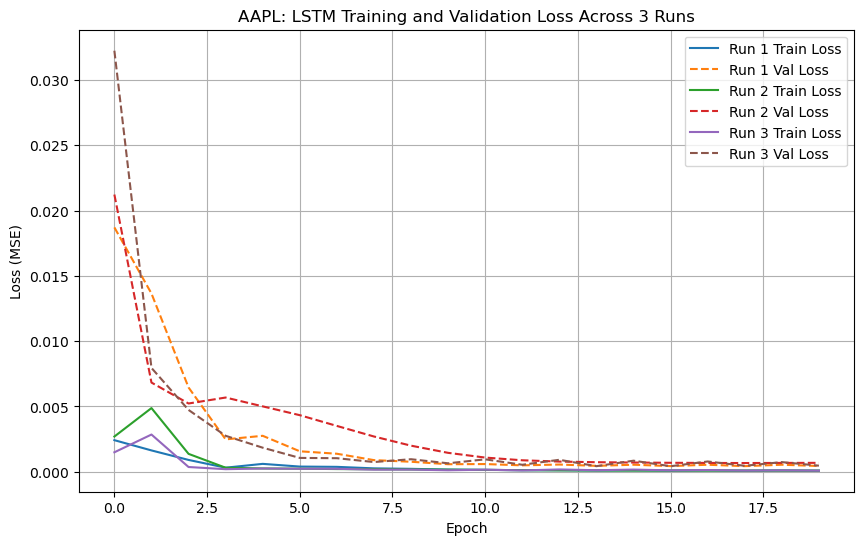

In [61]:
### 3.2 training plot
plt.figure(figsize=(10,6))
for run in range(3):
    history = histories[run]
    plt.plot(history.history['loss'], label=f'Run {run+1} Train Loss')
    plt.plot(history.history['val_loss'], '--', label=f'Run {run+1} Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title(f'{Tick}: LSTM Training and Validation Loss Across 3 Runs')
plt.legend()
plt.grid(True)
plt.show()

## Robustness Performance Analysis

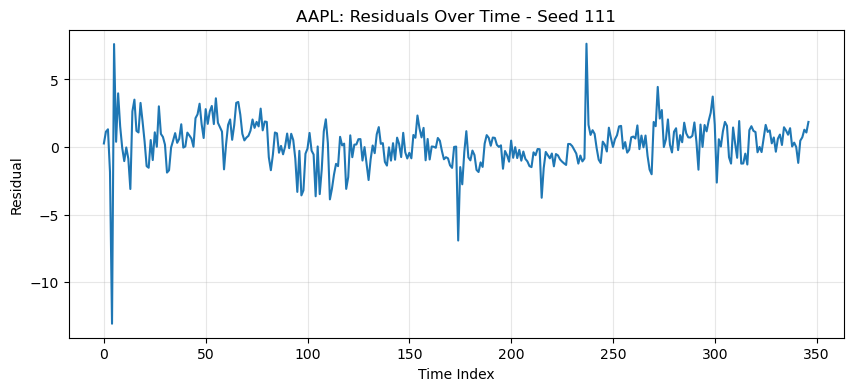

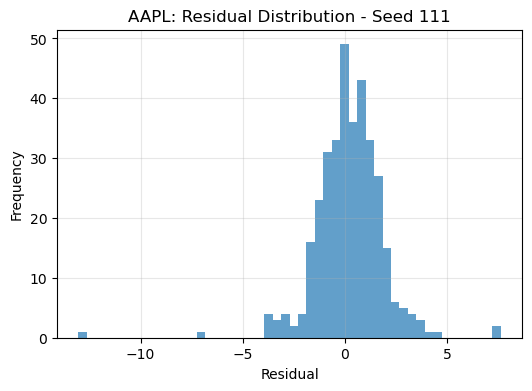

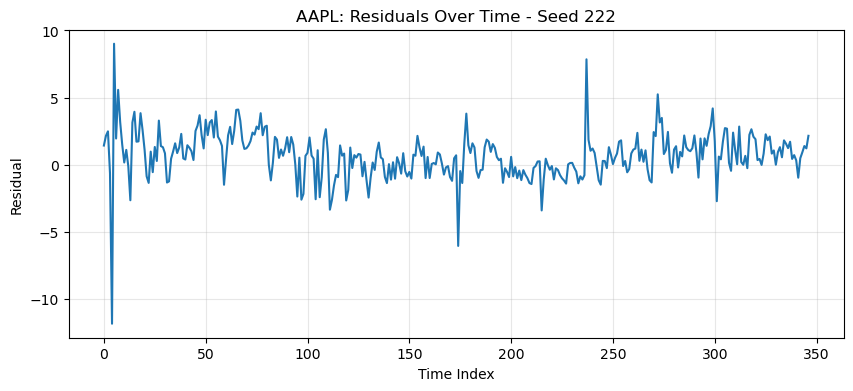

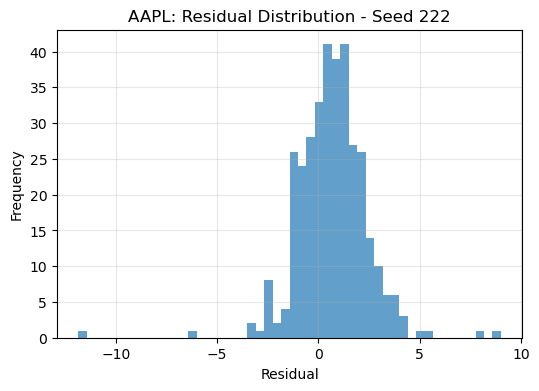

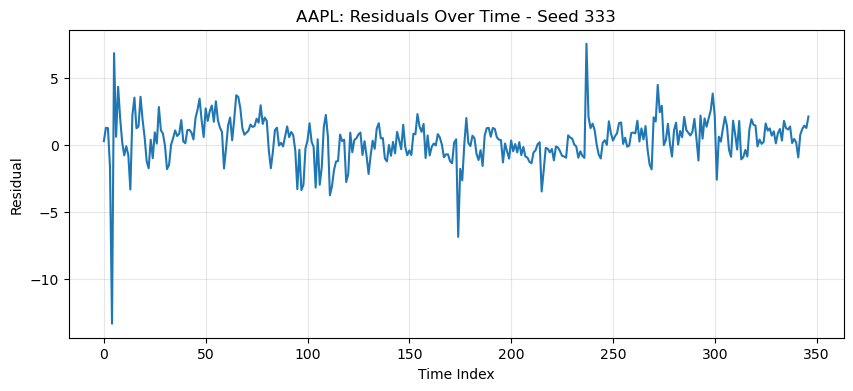

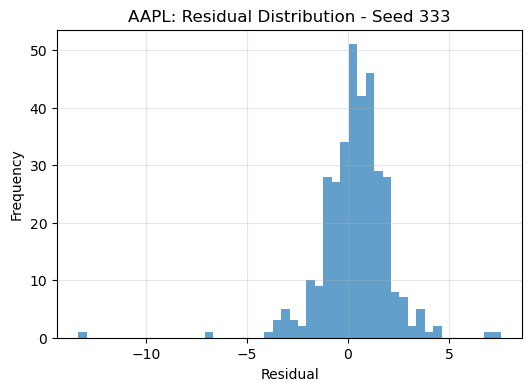

In [60]:
##### >>> 4. Model Robustness Performance Analysis

### >> 4.1 Plot: Residual Plot and Histrogram >> Loop through all predictions (3 seeds)
for i, pred in enumerate(predictions):
    residuals = pred["y_test"] - pred["y_pred"]
    
    # Residual over time
    plt.figure(figsize=(10,4))
    plt.plot(residuals, color="#1f77b4")
    plt.title(f"{Tick}: Residuals Over Time - Seed {pred['Seed']}")
    plt.xlabel("Time Index")
    plt.ylabel("Residual")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Residual histogram
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=50, alpha=0.7) #color="#ff7f0e", edgecolor="#ff7f0e"
    plt.title(f"{Tick}: Residual Distribution - Seed {pred['Seed']}")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()

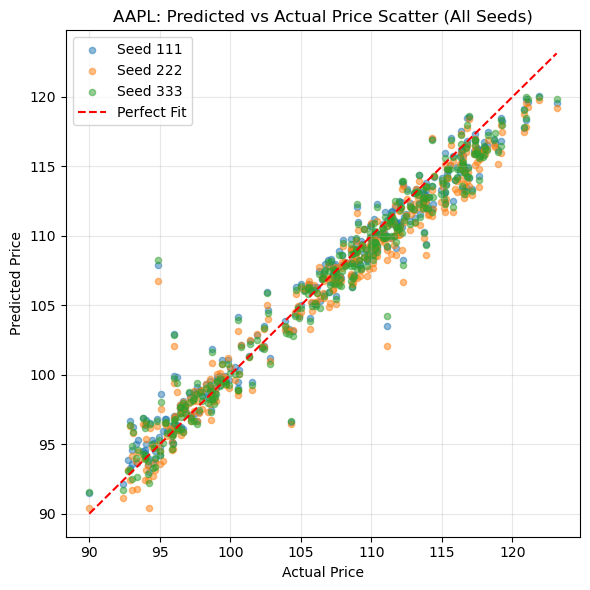

In [62]:
### >> 4.2 Plot: Predicted vs Actual 
## Overlay
plt.figure(figsize=(6,6))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i, pred in enumerate(predictions):
    plt.scatter(
        pred["y_test"],
        pred["y_pred"],
        alpha=0.5,
        s=20,
        color=colors[i],
        label=f"Seed {pred['Seed']}"
    )

# perfect prediction line
min_val = min([pred["y_test"].min() for pred in predictions])
max_val = max([pred["y_test"].max() for pred in predictions])
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"{Tick}: Predicted vs Actual Price Scatter (All Seeds)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


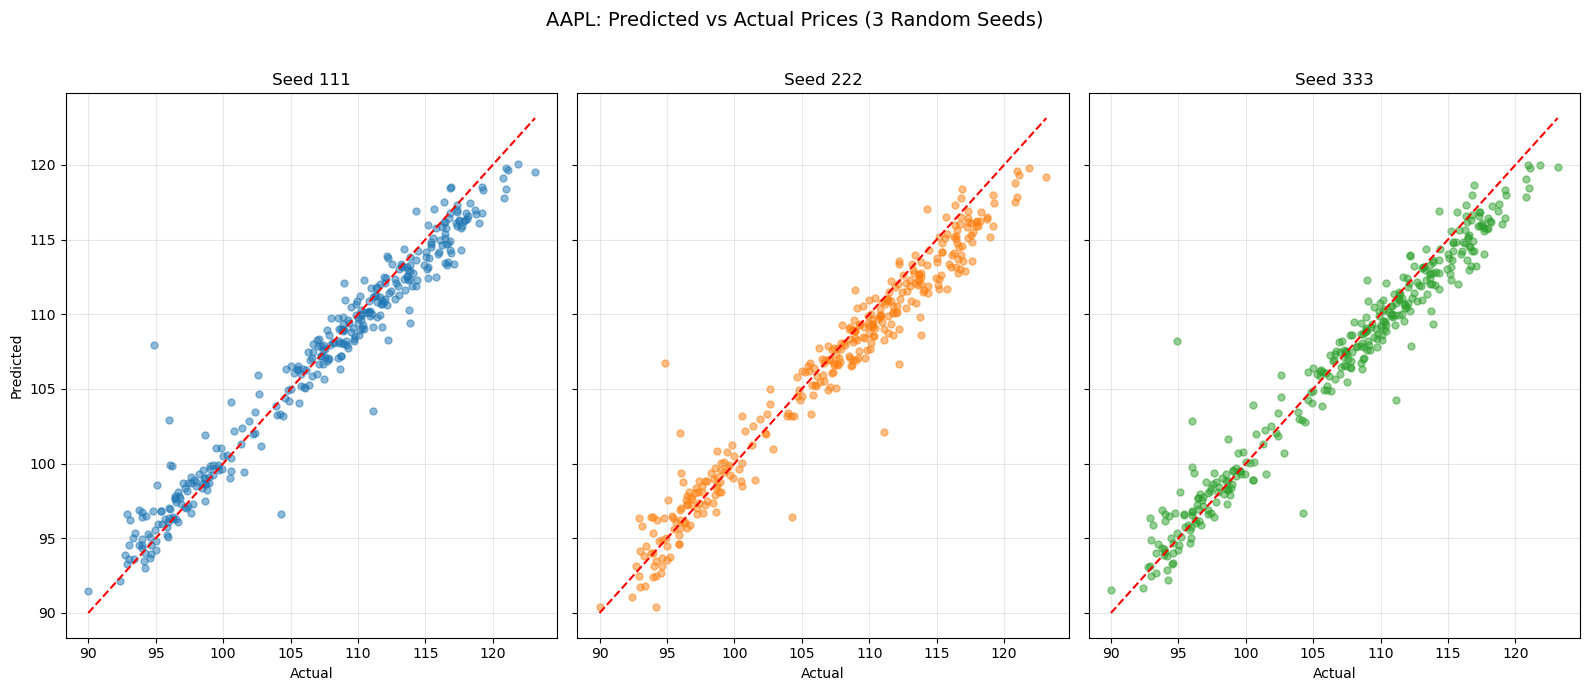

In [56]:
## >> [Option] Plot: Residual plot that compare three difference random run one panel per seed 

fig, axes = plt.subplots(1, 3, figsize=(16,7), sharex=True, sharey=True)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i, pred in enumerate(predictions):
    ax = axes[i]
    ax.scatter(pred["y_test"], pred["y_pred"], alpha=0.5, s=25, color=colors[i])
    ax.plot(
        [pred["y_test"].min(), pred["y_test"].max()],
        [pred["y_test"].min(), pred["y_test"].max()],
        color='red', linestyle='--'
    )
    ax.set_title(f"Seed {pred['Seed']}")
    ax.set_xlabel("Actual")
    if i == 0:
        ax.set_ylabel("Predicted")
    ax.grid(True, alpha=0.3)

plt.suptitle(f"{Tick}: Predicted vs Actual Prices (3 Random Seeds)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


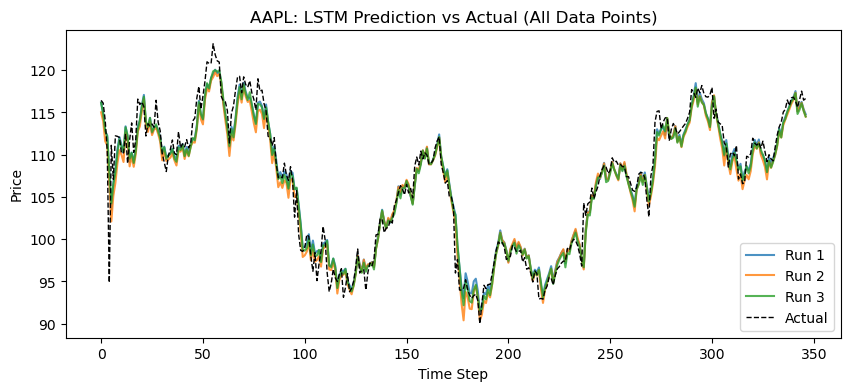

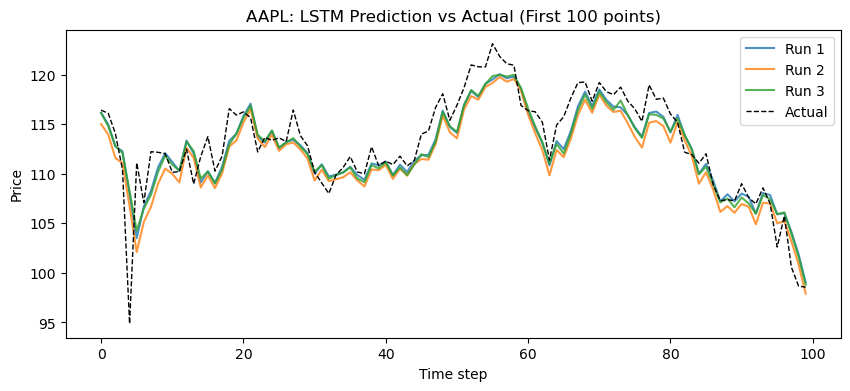

In [34]:
### >> 4.3 Plot: Quick prediction vs time step
# Plot predictions from each run
plt.figure(figsize=(10,4))
for i, pred in enumerate(predictions):
    plt.plot(pred["y_pred"], label=f"Run {pred['Run']}", alpha=0.8)

plt.plot(predictions[0]["y_test"], color="black", linewidth=1, linestyle="--", label="Actual")
plt.legend()
plt.title(f"{Tick}: LSTM Prediction vs Actual (All Data Points)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.show()


# Plot the first 100 data points for detailed view
plt.figure(figsize=(10,4))
for i, pred in enumerate(predictions):
    plt.plot(pred["y_pred"][:100], label=f"Run {pred['Run']}", alpha=0.8)
plt.plot(predictions[0]["y_test"][:100], color="black", linewidth=1, linestyle="--", label="Actual")
plt.legend()
plt.title(f"{Tick}: LSTM Prediction vs Actual (First 100 points)")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.show()


## Prediction

- Predicted/Actual Price vs Date Plot

- Prediction Function

In [ ]:
##### 5. Final Price - Date Plot and Prediction Over History

### >>> Plot: 5.1 Final Predicted/Actual Plot with date
## >> Melt date and prepare long format for plot
all_dates = df.index

# dates corresponding to y
look_back = 20
dates_y = all_dates[look_back:]  # start from day 21

# split dates into train and test
dates_train = dates_y[:split]
dates_test = dates_y[split:]

results_all = pd.DataFrame({"Date": dates_test, "Actual": predictions[0]["y_test"]})

# Add all prediction columns
for i, pred in enumerate(predictions):
    results_all[f"Pred{i+1}"] = pred["y_pred"]

# Convert to long format
results_long = results_all.melt(id_vars='Date',
                                value_vars=['Actual', 'Pred1', 'Pred2', 'Pred3'],
                                var_name='Type',
                                value_name='Price'
)

In [44]:
results_long

,Date,Type,Price
0,2015-08-18,Actual,116.430000
1,2015-08-19,Actual,116.099998
2,2015-08-20,Actual,114.080002
3,2015-08-21,Actual,110.430000
4,2015-08-24,Actual,94.870003
...,...,...,...
1383,2016-12-23,Pred3,114.818911
1384,2016-12-27,Pred3,115.317662
1385,2016-12-28,Pred3,116.073134
1386,2016-12-29,Pred3,115.179294


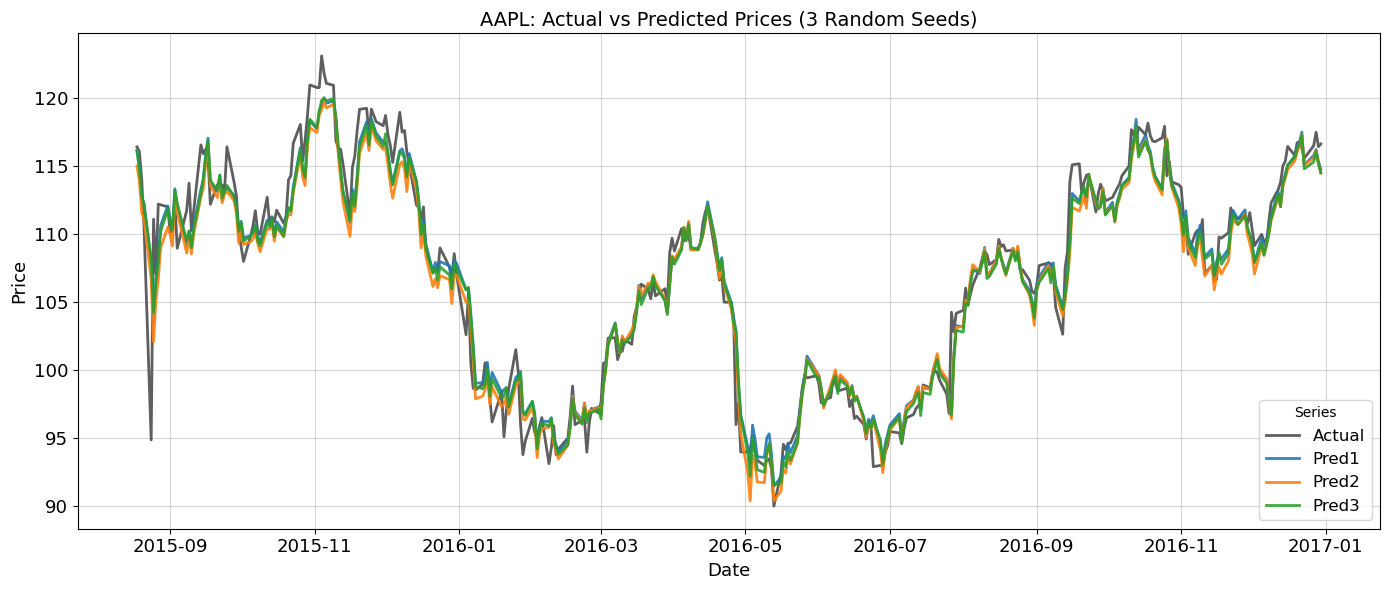

In [57]:
### >> Plot: Actual vs Predicted Price with Date
import seaborn as sns

plt.figure(figsize=(14,6))
palette = {"Actual": "#4e4e4e","Pred1": "#1f77b4", "Pred2": "#ff7f0e","Pred3": "#2ca02c"}

sns.lineplot(data=results_long,
             x='Date', y='Price', hue='Type', palette=palette, linewidth=2,alpha=0.9
)

plt.title(f"{Tick}: Actual vs Predicted Prices (3 Random Seeds)", fontsize=14)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Price", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.5)
plt.legend(title="Series", fontsize=12)
plt.tight_layout()
plt.show()



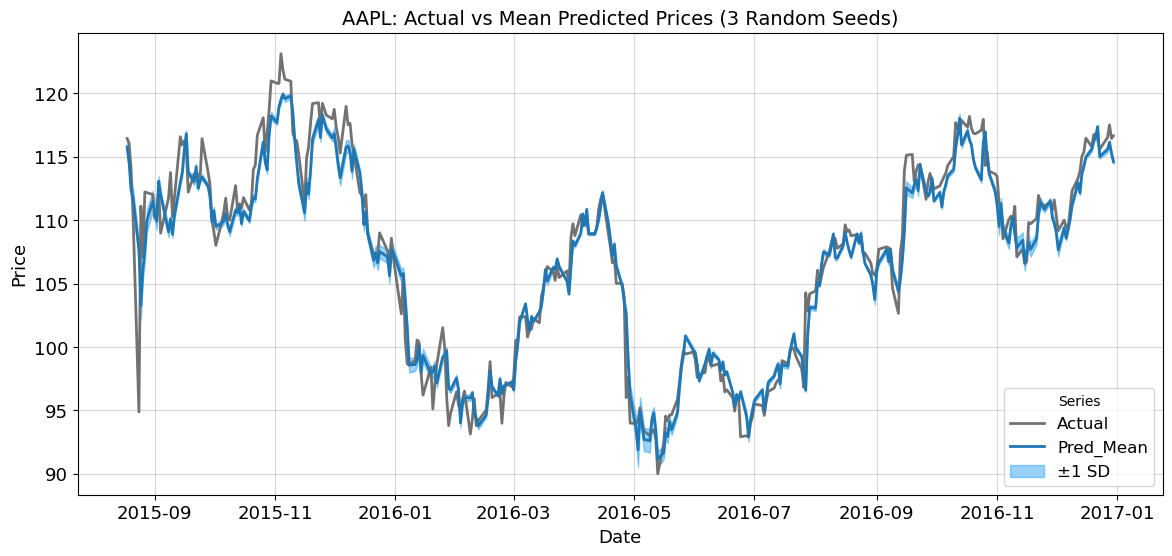

In [63]:
### [Option] Plot: Mean & Variability Band

results_all["Pred_Mean"] = results_all[["Pred1","Pred2","Pred3"]].mean(axis=1)
results_all["Pred_Std"] = results_all[["Pred1","Pred2","Pred3"]].std(axis=1)

plt.figure(figsize=(14,6))
plt.plot(results_all["Date"], results_all["Actual"], color="#727272", label="Actual", linewidth=2)
plt.plot(results_all["Date"], results_all["Pred_Mean"], color="#1f77b4", label="Pred_Mean", linewidth=2)
plt.fill_between(
    results_all["Date"],
    results_all["Pred_Mean"] - results_all["Pred_Std"],
    results_all["Pred_Mean"] + results_all["Pred_Std"],
    color="#008ff5", alpha=0.4, label="±1 SD"
)
plt.legend()
plt.grid(True, alpha=0.7)
plt.title(f"{Tick}: Actual vs Mean Predicted Prices (3 Random Seeds)",fontsize=14)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Price", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.5)
plt.legend(title="Series", fontsize=12)
plt.show()


In [66]:
### >> [Option] Plotly: Actual vs Predicted Price  with Date
import plotly.graph_objects as go; fig = go.Figure()

# Actual line (gray)
fig.add_trace(go.Scatter(x=results_all["Date"], y=results_all["Actual"],
                         mode='lines', name='Actual',line=dict(color='#727272', width=2)))

# Mean predicted line (blue)
fig.add_trace(go.Scatter(x=results_all["Date"], y=results_all["Pred_Mean"],
                         mode='lines', name='Pred_Mean', line=dict(color='#1f77b4', width=2)))

# ±1 SD shaded band
fig.add_trace(go.Scatter(x=pd.concat([results_all["Date"], results_all["Date"][::-1]]),
                         y=pd.concat([results_all["Pred_Mean"] + results_all["Pred_Std"],
                                      (results_all["Pred_Mean"] - results_all["Pred_Std"])[::-1]]),
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.5)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='±1 SD'
))

# Layout with stronger grid
fig.update_layout(width=1200,height=600,
                title_font_size=20, xaxis_title_font_size=16,yaxis_title_font_size=16,legend_title_font_size=14,
                    #   plot_bgcolor=plot_bgcolor,        # plot area background
                    #   paper_bgcolor=background_color,   # figure background
                margin=dict(l=50, r=50, t=60, b=50),
    
                title=f"{Tick}: Actual vs Mean Predicted Prices (3 Random Seeds)",
                xaxis_title="Date",
                yaxis_title="Price",
                template="plotly_white",
                legend_title="Series",
                font=dict(size=13),
                hovermode="x unified",
                xaxis=dict(
                    showgrid=True,
                    gridcolor='lightgray',
                    gridwidth=1.5  # increase grid thickness
                ),
                yaxis=dict(
                    showgrid=True,
                    gridcolor='lightgray',
                    gridwidth=1.5  # increase grid thickness
                )
            )

fig.update_xaxes(tickfont=dict(size=16))
fig.update_yaxes(tickfont=dict(size=16))
fig.show()

## save your Plotly figure as a standalone, interactive HTML file (zoomable, hoverable, no server required).
fig.write_html(f"{Tick}_actual_vs_predicted.html")

# allow to open automatically in the default browser
import webbrowser
webbrowser.open(f"{Tick}_actual_vs_predicted.html")  




True

In [ ]:
### >>> 5.2. Prediction Function
### >> create predition over the history 
def predict_over_history(df, model, scaler, look_back=20):
    """
    Generate next-day predictions over the full history of the dataset.
    
    Returns a DataFrame with:
      - actual_close: the actual close price
      - predicted_close: model's predicted next-day close
      - residual: difference between actual and predicted
    """
    n_features = df.shape[1]
    df_scaled = scaler.transform(df)
    
    predicted = []
    actual = []
    dates = []
    
    # slide over history
    for i in tqdm(range(look_back, len(df_scaled))):
        input_scaled = df_scaled[i-look_back:i, :].reshape(1, look_back, n_features)
        pred_scaled = model.predict(input_scaled, verbose=0)
        
        # inverse transform predicted close
        dummy = np.zeros((1, n_features))
        dummy[0, 0] = pred_scaled[0, 0]
        pred_close = scaler.inverse_transform(dummy)[0, 0]
        
        predicted.append(pred_close)
        actual.append(df['close'].values[i])
        dates.append(df.index[i])
    
    # create DataFrame
    pred_df = pd.DataFrame({
        'actual_close': actual,
        'predicted_close': predicted,
        'residual': np.array(actual) - np.array(predicted)
    }, index=dates)
    
    return pred_df


100%|██████████| 1735/1735 [01:43<00:00, 16.70it/s]


            actual_close  predicted_close  residual
2016-12-16    115.970001       115.091108  0.878893
2016-12-19    116.639999       115.655606  0.984393
2016-12-20    116.949997       116.289779  0.660218
2016-12-21    117.059998       116.626824  0.433174
2016-12-22    116.290001       117.281121 -0.991120
2016-12-23    116.519997       114.818898  1.701099
2016-12-27    117.260002       115.317675  1.942327
2016-12-28    116.760002       116.073140  0.686862
2016-12-29    116.730003       115.179300  1.550703
2016-12-30    115.820000       114.523307  1.296693


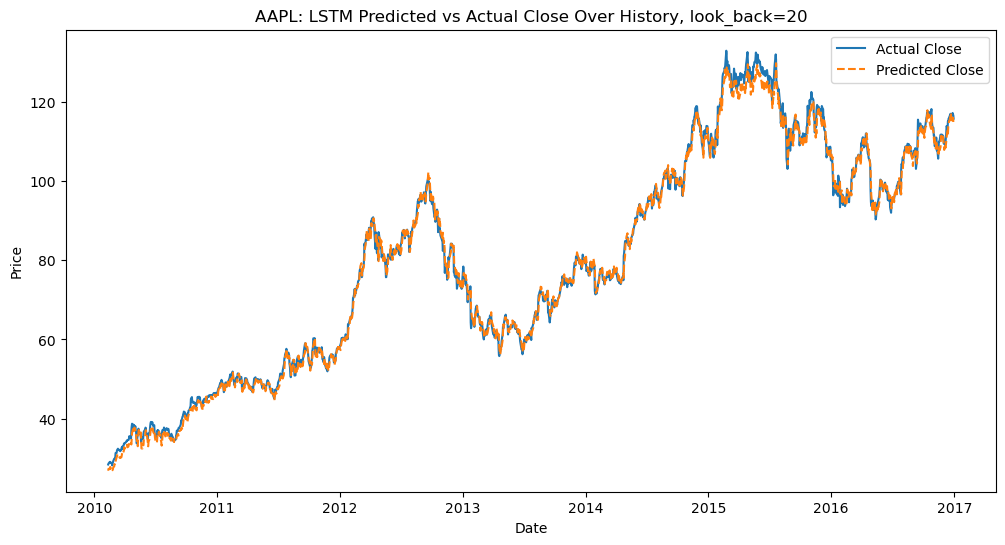

In [59]:
### >> Test with look_back = 20

predictions_table = predict_over_history(df, model_lstm, scaler, look_back=20)
print(predictions_table.tail(10))  # last 10 days with predictions

## plot the overall history
plt.figure(figsize=(12,6))
plt.plot(predictions_table.index, predictions_table['actual_close'], label='Actual Close')
plt.plot(predictions_table.index, predictions_table['predicted_close'], label='Predicted Close', linestyle='--')
plt.title(f'{Tick}: LSTM Predicted vs Actual Close Over History, look_back=20')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [77]:
### >>  [Option] Plotly: Actual vs Predicted Price Over the History
# Create figure
fig = go.Figure()

# Actual close
fig.add_trace(go.Scatter(
    x=predictions_table.index,
    y=predictions_table['actual_close'],
    mode='lines',
    name='Actual Close',
    line=dict(color='steelblue', width=2)
))

# Predicted close
fig.add_trace(go.Scatter(
    x=predictions_table.index,
    y=predictions_table['predicted_close'],
    mode='lines',
    name='Predicted Close',
    line=dict(color="tomato", width=2.5, dash='dash')
    # dash options: 'solid', 'dash', 'dot', 'dashdot', or specific patterns (e.g., '5px 5px' for a custom dash-dot pattern).
))

# Layout with stronger grid
fig.update_layout(width=1200,height=600,
                title_font_size=20, xaxis_title_font_size=16,yaxis_title_font_size=16,legend_title_font_size=14,
                # plot_bgcolor=plot_bgcolor,        # plot area background
                # paper_bgcolor=background_color,   # figure background
                margin=dict(l=50, r=50, t=60, b=50),

                title=f"{Tick}: Actual vs Mean Predicted Prices (3 Random Seeds)",
                xaxis_title="Date",
                yaxis_title="Price",
                template="plotly_white",
                legend_title="Series",
                font=dict(size=13),
                hovermode="x unified",
                xaxis=dict(
                    showgrid=True,
                    gridcolor='lightgray',
                    gridwidth=1.5  # increase grid thickness
                ),
                yaxis=dict(
                    showgrid=True,
                    gridcolor='lightgray',
                    gridwidth=1.5  # increase grid thickness
                )
            )

fig.update_xaxes(tickfont=dict(size=16))
fig.update_yaxes(tickfont=dict(size=16))
fig.show()

# Optional — export to HTML for sharing
fig.write_html(f"{Tick}_LSTM_Pred_vs_Actual_history.html")
print(f"✅ Plotly chart saved as '{Tick}_LSTM_Pred_vs_Actual.html'")
webbrowser.open(f"{Tick}_LSTM_Pred_vs_Actual_history.html")

✅ Plotly chart saved as 'AAPL_LSTM_Pred_vs_Actual.html'


True

In [78]:
##### >>> Save Model

model_lstm.save(f"{Tick}_lstm_model.h5")

# # Load in another script
# from tensorflow.keras.models import load_model
# model = load_model("aapl_lstm_model.h5")
